In [2]:
#Algoritma Random forest
import pandas as pd
import yfinance as yf
import numpy as np
import time
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Library dan konfigurasi awal berhasil dimuat.")

Library dan konfigurasi awal berhasil dimuat.


In [3]:
def create_features(df, feature_config):
    """
    Membuat fitur teknikal berdasarkan konfigurasi yang diberikan.
    """
    df_feat = df.copy()
    if feature_config.get('lags'):
        for i in range(1, 6): df_feat[f'lag_{i}'] = df_feat['close'].shift(i)
    if feature_config.get('indicators'):
        df_feat.ta.sma(10, append=True); df_feat.ta.sma(30, append=True)
        df_feat.ta.rsi(14, append=True); df_feat.ta.bbands(20, append=True)
    df_feat.dropna(inplace=True)
    return df_feat

def prepare_data_for_model(df_features, config):
    """
    Mempersiapkan data (X, y), melakukan splitting, dan scaling.
    """
    y = df_features['close']
    X = df_features.copy()
    X.drop(columns=['close', 'adj_close'], errors='ignore', inplace=True)
    split_idx = int(len(X) * config['split_ratio'])
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, X_train.columns, scaler

def train_and_predict(model, model_params, X_train, y_train, X_test):
    """
    Melatih model dan menghasilkan prediksi.
    """
    model.set_params(**model_params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

def evaluate_predictions(predictions, y_test):
    """
    Mengevaluasi prediksi.
    """
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'MAE': mean_absolute_error(y_test, predictions),
        'MAPE (%)': mean_absolute_percentage_error(y_test, predictions) * 100,
        'R2 Score': r2_score(y_test, predictions)
    }
    return metrics

def run_experiment(data, config):
    """
    Menjalankan satu siklus eksperimen lengkap.
    """
    print(f"-- Menjalankan: {config['id']} ({config['name']})")
    df_with_features = create_features(data, config['features'])
    X_train_scaled, X_test_scaled, y_train, y_test, feature_names, _ = prepare_data_for_model(df_with_features, config)
    model = config['model']
    preds = train_and_predict(model, config['model_params'], X_train_scaled, y_train, X_test_scaled)
    metrics = evaluate_predictions(preds, y_test)
    result = {'ID': config['id'], 'Model': config['model_name'], 'Eksperimen': config['name'], **metrics}
    return result, model, feature_names

def visualize_experiment(data, config, model, feature_names, title_prefix=""):
    """
    Membuat visualisasi untuk hasil eksperimen.
    """
    print(f"\nMembuat visualisasi untuk: {title_prefix} {config['id']}")
    df_with_features = create_features(data, config['features'])
    X_train_scaled, X_test_scaled, y_train, y_test, _, _ = prepare_data_for_model(df_with_features, config)
    
    predictions = train_and_predict(model, config['model_params'], X_train_scaled, y_train, X_test_scaled)
    
    plt.figure(figsize=(16, 7))
    plt.plot(y_test.index, y_test, label='Harga Aktual (Uji)', color='navy', linewidth=2)
    plt.plot(y_test.index, predictions, label=f'Prediksi {config["id"]}', color='red', linestyle='--')
    plt.title(f'{title_prefix} Hasil Prediksi: {config["id"]} - {config["name"]}', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12); plt.ylabel('Harga Penutupan (IDR)', fontsize=12)
    plt.legend(); plt.grid(True); plt.show()

    if hasattr(model, 'feature_importances_') and len(model.feature_importances_) > 0:
        importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=importances.head(10))
        plt.title(f'{title_prefix} 10 Fitur Terpenting - {config["id"]}', fontsize=16)
        plt.show()

print("Fungsi-fungsi utama berhasil didefinisikan.")



Fungsi-fungsi utama berhasil didefinisikan.


In [4]:

nama_file_csv = "dataset_IDR_X_2019_2024.csv"

print(f"Memuat data dari file lokal: {nama_file_csv}...")

raw_data = pd.read_csv(nama_file_csv, index_col=0, parse_dates=True)

raw_data.columns = raw_data.columns.str.lower()
raw_data.columns = raw_data.columns.str.replace(' ', '_')


print("\nData berhasil dimuat dari file CSV.")

print("Verifikasi Tipe Data (Dtype):")
raw_data.info() 


print("\nContoh Data:")
display(raw_data.head())

Memuat data dari file lokal: dataset_IDR_X_2019_2024.csv...

Data berhasil dimuat dari file CSV.
Verifikasi Tipe Data (Dtype):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1564 entries, 2019-01-01 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1564 non-null   float64
 1   high    1564 non-null   float64
 2   low     1564 non-null   float64
 3   open    1564 non-null   float64
 4   volume  1564 non-null   float64
dtypes: float64(5)
memory usage: 73.3 KB

Contoh Data:


,close,high,low,open,volume
Date,,,,,
2019-01-01,14460.000000,14460.0,14460.000000,14460.000000,0.0
2019-01-02,14460.000000,14513.0,14373.000000,14460.000000,0.0
2019-01-03,14409.700195,14502.5,14367.900391,14409.700195,0.0
2019-01-04,14375.400391,14403.0,14211.000000,14375.400391,0.0
2019-01-07,14267.000000,14263.0,14008.000000,14263.000000,0.0


In [5]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

STD_FEATURES = {'lags': True, 'indicators': True}
STD_TARGET = 'absolute'
all_configs = []

block_80_configs = [
    {'id': 'RF-B-80', 'name': 'Baseline (Split 80/20)', 'model': rf, 'model_params': {'n_estimators': 100}},
    {'id': 'RF-T1-80', 'name': 'Tuned: More Trees (Split 80/20)', 'model': rf, 'model_params': {'n_estimators': 300}},
    {'id': 'RF-T2-80', 'name': 'Tuned: Deeper Trees (Split 80/20)', 'model': rf, 'model_params': {'n_estimators': 150, 'min_samples_leaf': 3}},
    {'id': 'RF-T3-80', 'name': 'Tuned: Max Features (Split 80/20)', 'model': rf, 'model_params': {'n_estimators': 150, 'max_features': 'sqrt'}},
    {'id': 'RF-T4-80', 'name': 'Tuned: MAE Criterion (Split 80/20)', 'model': rf, 'model_params': {'n_estimators': 100, 'criterion': 'absolute_error'}},
]
for config in block_80_configs:
    config.update({'features': STD_FEATURES, 'split_ratio': 0.8, 'target': STD_TARGET, 'model_name': 'RandomForestRegressor'})
all_configs.extend(block_80_configs)

block_70_configs = [
    {'id': 'RF-B-70', 'name': 'Baseline (Split 70/30)', 'model': rf, 'model_params': {'n_estimators': 100}},
    {'id': 'RF-T1-70', 'name': 'Tuned: More Trees (Split 70/30)', 'model': rf, 'model_params': {'n_estimators': 300}},
    {'id': 'RF-T2-70', 'name': 'Tuned: Deeper Trees (Split 70/30)', 'model': rf, 'model_params': {'n_estimators': 150, 'min_samples_leaf': 3}},
    {'id': 'RF-T3-70', 'name': 'Tuned: Max Features (Split 70/30)', 'model': rf, 'model_params': {'n_estimators': 150, 'max_features': 'sqrt'}},
    {'id': 'RF-T4-70', 'name': 'Tuned: MAE Criterion (Split 70/30)', 'model': rf, 'model_params': {'n_estimators': 100, 'criterion': 'absolute_error'}},
]
for config in block_70_configs:
    config.update({'features': STD_FEATURES, 'split_ratio': 0.7, 'target': STD_TARGET, 'model_name': 'RandomForestRegressor'})
all_configs.extend(block_70_configs)

print(f"Total {len(all_configs)} konfigurasi eksperimen Random Forest berhasil dibuat.")

Total 10 konfigurasi eksperimen Random Forest berhasil dibuat.


In [6]:
all_results = []
models_trained = {}   
feature_names_map = {} 

start_total_time = time.time()

for config in all_configs:
    try:
        result, trained_model, feature_names = run_experiment(raw_data, config)
        all_results.append(result)
        models_trained[config['id']] = trained_model
        feature_names_map[config['id']] = feature_names

        print("--- Hasil Evaluasi Selesai ---")
        display(pd.DataFrame([result]).set_index('ID'))
        print("-" * 70)
        
    except Exception as e:
        print(f"!!! GAGAL: {config['id']} ({config['name']}) - Error: {e}")
        all_results.append({
            'ID': config['id'], 'Model': config['model_name'], 'Eksperimen': config['name'], 
            'RMSE': np.nan, 'MAE': np.nan, 'MAPE (%)': np.nan, 'R2 Score': np.nan
        })

end_total_time = time.time()
print(f"\n\nEKSEKUSI SEMUA {len(all_configs)} EKSPERIMEN SELESAI.")
print(f"Total waktu yang dibutuhkan: {((end_total_time - start_total_time) / 60):.2f} menit.")

-- Menjalankan: RF-B-80 (Baseline (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-B-80,RandomForestRegressor,Baseline (Split 80/20),115.62433,76.345241,0.474599,0.872161


----------------------------------------------------------------------
-- Menjalankan: RF-T1-80 (Tuned: More Trees (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-T1-80,RandomForestRegressor,Tuned: More Trees (Split 80/20),117.443292,76.62278,0.476046,0.868107


----------------------------------------------------------------------
-- Menjalankan: RF-T2-80 (Tuned: Deeper Trees (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-T2-80,RandomForestRegressor,Tuned: Deeper Trees (Split 80/20),110.715617,71.177547,0.44206,0.882785


----------------------------------------------------------------------
-- Menjalankan: RF-T3-80 (Tuned: Max Features (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-T3-80,RandomForestRegressor,Tuned: Max Features (Split 80/20),126.570726,84.752726,0.528163,0.846809


----------------------------------------------------------------------
-- Menjalankan: RF-T4-80 (Tuned: MAE Criterion (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-T4-80,RandomForestRegressor,Tuned: MAE Criterion (Split 80/20),132.252893,87.909974,0.547483,0.832746


----------------------------------------------------------------------
-- Menjalankan: RF-B-70 (Baseline (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-B-70,RandomForestRegressor,Baseline (Split 70/30),138.720008,87.965791,0.550771,0.902787


----------------------------------------------------------------------
-- Menjalankan: RF-T1-70 (Tuned: More Trees (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-T1-70,RandomForestRegressor,Tuned: More Trees (Split 70/30),143.293771,90.113368,0.56383,0.89627


----------------------------------------------------------------------
-- Menjalankan: RF-T2-70 (Tuned: Deeper Trees (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-T2-70,RandomForestRegressor,Tuned: Deeper Trees (Split 70/30),137.940506,86.330054,0.540354,0.903876


----------------------------------------------------------------------
-- Menjalankan: RF-T3-70 (Tuned: Max Features (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-T3-70,RandomForestRegressor,Tuned: Max Features (Split 70/30),137.940506,86.330054,0.540354,0.903876


----------------------------------------------------------------------
-- Menjalankan: RF-T4-70 (Tuned: MAE Criterion (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-T4-70,RandomForestRegressor,Tuned: MAE Criterion (Split 70/30),138.720008,87.965791,0.550771,0.902787


----------------------------------------------------------------------


EKSEKUSI SEMUA 10 EKSPERIMEN SELESAI.
Total waktu yang dibutuhkan: 0.07 menit.



##########################################################################################
##          ANALISIS MENDALAM & VISUALISASI HASIL EKSPERIMEN (RANDOM FOREST)          ##
##########################################################################################


--- METRIK TERBAIK (SPLIT 80/20) ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-T2-80,RandomForestRegressor,Tuned: Deeper Trees (Split 80/20),110.715617,71.177547,0.442060,0.882785
RF-B-80,RandomForestRegressor,Baseline (Split 80/20),115.624330,76.345241,0.474599,0.872161
RF-T1-80,RandomForestRegressor,Tuned: More Trees (Split 80/20),117.443292,76.622780,0.476046,0.868107
RF-T3-80,RandomForestRegressor,Tuned: Max Features (Split 80/20),126.570726,84.752726,0.528163,0.846809
RF-T4-80,RandomForestRegressor,Tuned: MAE Criterion (Split 80/20),132.252893,87.909974,0.547483,0.832746



--> PEMENANG (SPLIT 80/20): RF-T2-80


--- VISUALISASI PEMENANG (SPLIT 80/20) ---

Membuat visualisasi untuk: [PEMENANG RF - Split 80/20] RF-T2-80


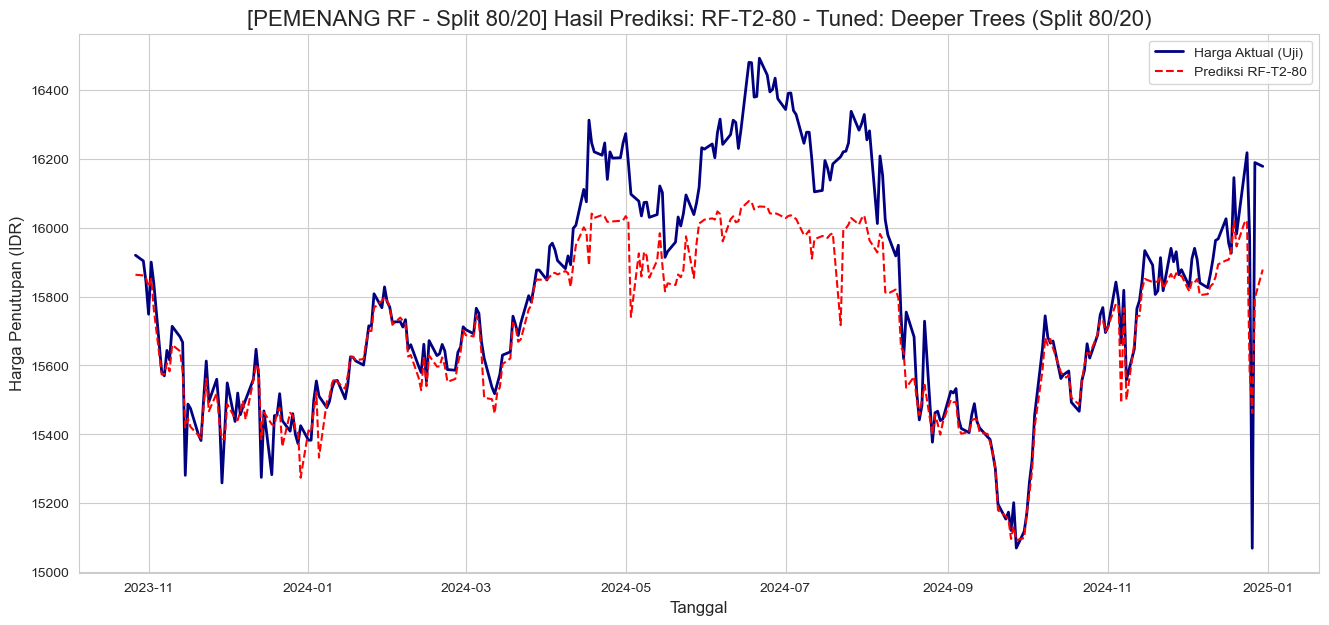

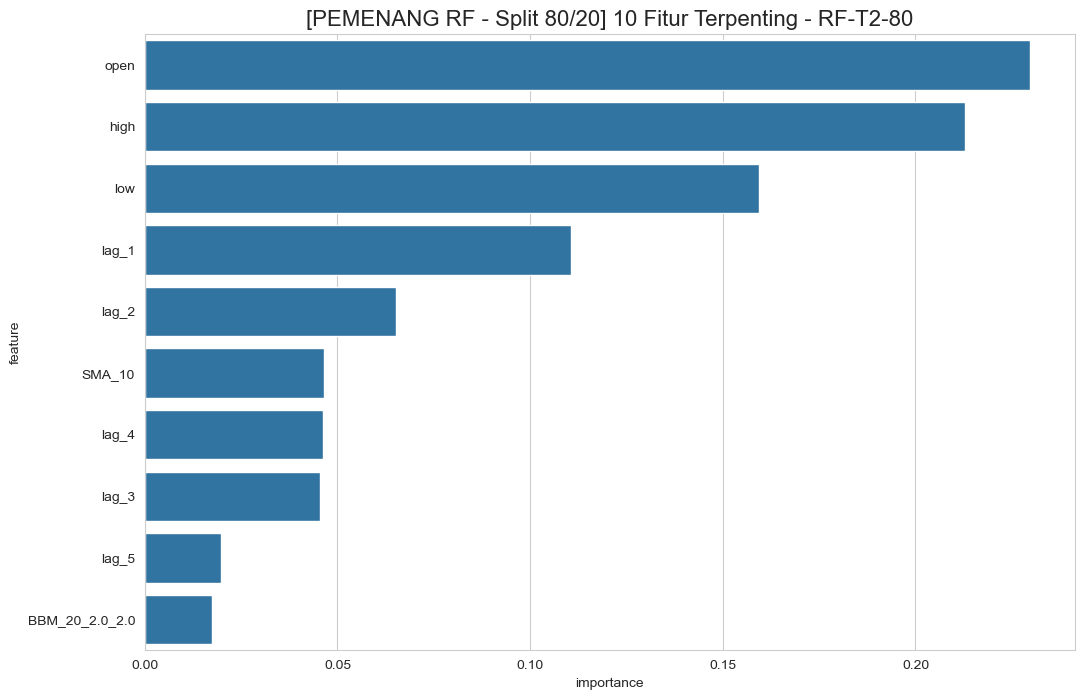


--- METRIK TERBAIK (SPLIT 70/30) ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
RF-T3-70,RandomForestRegressor,Tuned: Max Features (Split 70/30),137.940506,86.330054,0.540354,0.903876
RF-T2-70,RandomForestRegressor,Tuned: Deeper Trees (Split 70/30),137.940506,86.330054,0.540354,0.903876
RF-B-70,RandomForestRegressor,Baseline (Split 70/30),138.720008,87.965791,0.550771,0.902787
RF-T4-70,RandomForestRegressor,Tuned: MAE Criterion (Split 70/30),138.720008,87.965791,0.550771,0.902787
RF-T1-70,RandomForestRegressor,Tuned: More Trees (Split 70/30),143.293771,90.113368,0.563830,0.896270



--> PEMENANG (SPLIT 70/30): RF-T2-70


--- VISUALISASI PEMENANG (SPLIT 70/30) ---

Membuat visualisasi untuk: [PEMENANG RF - Split 70/30] RF-T2-70


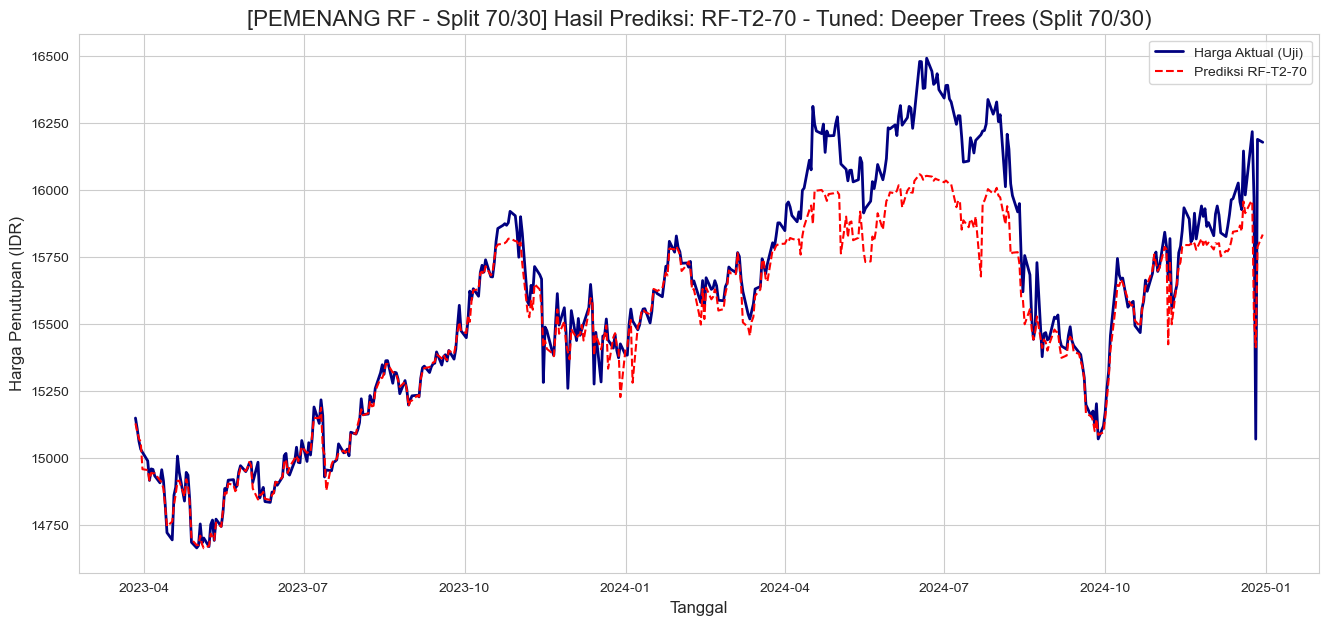

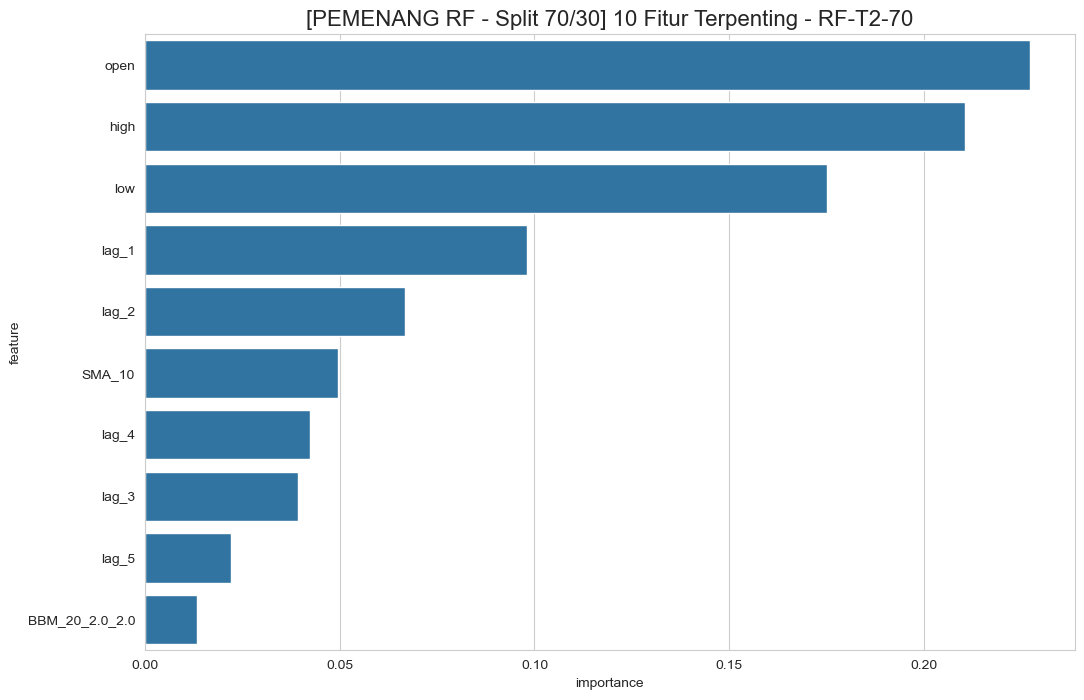


******************************************************************************************
**                    PENENTUAN JUARA KESELURUHAN (RANDOM FOREST)                     **
******************************************************************************************


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
RF-T2-80,RandomForestRegressor,Tuned: Deeper Trees (Split 80/20),110.715617,71.177547,0.442060,0.882785
RF-T2-70,RandomForestRegressor,Tuned: Deeper Trees (Split 70/30),137.940506,86.330054,0.540354,0.903876



===> JUARA KESELURUHAN RF adalah: RF-T2-80!

--- DETAIL SANG JUARA ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
RF-T2-80,RandomForestRegressor,Tuned: Deeper Trees (Split 80/20),110.715617,71.177547,0.44206,0.882785


In [7]:
results_df = pd.DataFrame(all_results).set_index('ID')

if not results_df.dropna().empty:
    print("\n" + "#"*90)
    print("##" + " ANALISIS MENDALAM & VISUALISASI HASIL EKSPERIMEN (RANDOM FOREST) ".center(84) + "##")
    print("#"*90 + "\n")

    results_80 = results_df[results_df.index.str.contains('-80')]
    if not results_80.empty:
        best_id_80 = results_80['MAPE (%)'].idxmin()
        print("\n--- METRIK TERBAIK (SPLIT 80/20) ---")
        display(results_80.sort_values('MAPE (%)'))
        print(f"\n--> PEMENANG (SPLIT 80/20): {best_id_80}\n")
        print("\n--- VISUALISASI PEMENANG (SPLIT 80/20) ---")
        best_config_80 = next(c for c in all_configs if c['id'] == best_id_80)
        visualize_experiment(raw_data, best_config_80, models_trained[best_id_80], feature_names_map[best_id_80], title_prefix=f"[PEMENANG RF - Split 80/20]")
        
    results_70 = results_df[results_df.index.str.contains('-70')]
    if not results_70.empty:
        best_id_70 = results_70['MAPE (%)'].idxmin()
        print("\n--- METRIK TERBAIK (SPLIT 70/30) ---")
        display(results_70.sort_values('MAPE (%)'))
        print(f"\n--> PEMENANG (SPLIT 70/30): {best_id_70}\n")
        print("\n--- VISUALISASI PEMENANG (SPLIT 70/30) ---")
        best_config_70 = next(c for c in all_configs if c['id'] == best_id_70)
        visualize_experiment(raw_data, best_config_70, models_trained[best_id_70], feature_names_map[best_id_70], title_prefix=f"[PEMENANG RF - Split 70/30]")

    if not results_70.empty and not results_80.empty:
        winner_80_result = results_df.loc[best_id_80]
        winner_70_result = results_df.loc[best_id_70]
        print("\n" + "*"*90 + "\n**" + " PENENTUAN JUARA KESELURUHAN (RANDOM FOREST) ".center(84) + "**\n" + "*"*90)
        display(pd.DataFrame([winner_80_result, winner_70_result]))
        ultimate_champion_id = results_df['MAPE (%)'].idxmin()
        print(f"\n===> JUARA KESELURUHAN RF adalah: {ultimate_champion_id}!")
        champion_details = results_df.loc[ultimate_champion_id]
        print("\n--- DETAIL SANG JUARA ---")
        display(pd.DataFrame(champion_details).T)
else:
    print("Tidak ada hasil eksperimen yang berhasil untuk dianalisis.")

In [8]:
#Algoritma XGBoost
import pandas as pd
import yfinance as yf
import numpy as np
import time
import pandas_ta as ta
from xgboost import XGBRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Library dan konfigurasi awal berhasil dimuat.")

Library dan konfigurasi awal berhasil dimuat.


In [9]:
def create_features(df, feature_config):
    """
    Membuat fitur teknikal berdasarkan konfigurasi yang diberikan.
    """
    df_feat = df.copy()
    if feature_config.get('lags'):
        for i in range(1, 6): df_feat[f'lag_{i}'] = df_feat['close'].shift(i)
    if feature_config.get('indicators'):
        df_feat.ta.sma(10, append=True); df_feat.ta.sma(30, append=True)
        df_feat.ta.rsi(14, append=True); df_feat.ta.bbands(20, append=True)
    df_feat.dropna(inplace=True)
    return df_feat

def prepare_data_for_model(df_features, config):
    """
    Mempersiapkan data (X, y), melakukan splitting, dan scaling.
    """
    y = df_features['close']
    X = df_features.copy()
    X.drop(columns=['close', 'adj_close'], errors='ignore', inplace=True)
    split_idx = int(len(X) * config['split_ratio'])
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, X_train.columns, scaler

def train_and_predict(model, model_params, X_train, y_train, X_test, y_test): 
    """
    Melatih model dan menghasilkan prediksi.
    """
    model.set_params(**model_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    predictions = model.predict(X_test)
    return predictions

def evaluate_predictions(predictions, y_test):
    """
    Mengevaluasi prediksi.
    """
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'MAE': mean_absolute_error(y_test, predictions),
        'MAPE (%)': mean_absolute_percentage_error(y_test, predictions) * 100,
        'R2 Score': r2_score(y_test, predictions)
    }
    return metrics

def run_experiment(data, config):
    """
    Menjalankan satu siklus eksperimen lengkap.
    """
    print(f"-- Menjalankan: {config['id']} ({config['name']})")
    df_with_features = create_features(data, config['features'])
    X_train_scaled, X_test_scaled, y_train, y_test, feature_names, _ = prepare_data_for_model(df_with_features, config)
    model = config['model']
    preds = train_and_predict(model, config['model_params'], X_train_scaled, y_train, X_test_scaled, y_test)
    metrics = evaluate_predictions(preds, y_test)
    result = {'ID': config['id'], 'Model': config['model_name'], 'Eksperimen': config['name'], **metrics}
    return result, model, feature_names

def visualize_experiment(data, config, model, feature_names, title_prefix=""):
    """
    Membuat visualisasi untuk hasil eksperimen.
    """
    print(f"\nMembuat visualisasi untuk: {title_prefix} {config['id']}")
    df_with_features = create_features(data, config['features'])
    X_train_scaled, X_test_scaled, y_train, y_test, _, _ = prepare_data_for_model(df_with_features, config)
    
    predictions = train_and_predict(model, config['model_params'], X_train_scaled, y_train, X_test_scaled, y_test)
    
    plt.figure(figsize=(16, 7))
    plt.plot(y_test.index, y_test, label='Harga Aktual (Uji)', color='navy', linewidth=2)
    plt.plot(y_test.index, predictions, label=f'Prediksi {config["id"]}', color='red', linestyle='--')
    plt.title(f'{title_prefix} Hasil Prediksi: {config["id"]} - {config["name"]}', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12); plt.ylabel('Harga Penutupan (IDR)', fontsize=12)
    plt.legend(); plt.grid(True); plt.show()

    if hasattr(model, 'feature_importances_') and len(model.feature_importances_) > 0:
        importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=importances.head(10))
        plt.title(f'{title_prefix} 10 Fitur Terpenting - {config["id"]}', fontsize=16)
        plt.show()

print("Fungsi-fungsi utama berhasil didefinisikan.")

Fungsi-fungsi utama berhasil didefinisikan.


In [10]:

nama_file_csv = "dataset_IDR_X_2019_2024.csv"

print(f"Memuat data dari file lokal: {nama_file_csv}...")

raw_data = pd.read_csv(nama_file_csv, index_col=0, parse_dates=True)

raw_data.columns = raw_data.columns.str.lower()
raw_data.columns = raw_data.columns.str.replace(' ', '_')


print("\nData berhasil dimuat dari file CSV.")

print("Verifikasi Tipe Data (Dtype):")
raw_data.info() 


print("\nContoh Data:")
display(raw_data.head())

Memuat data dari file lokal: dataset_IDR_X_2019_2024.csv...

Data berhasil dimuat dari file CSV.
Verifikasi Tipe Data (Dtype):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1564 entries, 2019-01-01 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1564 non-null   float64
 1   high    1564 non-null   float64
 2   low     1564 non-null   float64
 3   open    1564 non-null   float64
 4   volume  1564 non-null   float64
dtypes: float64(5)
memory usage: 73.3 KB

Contoh Data:


,close,high,low,open,volume
Date,,,,,
2019-01-01,14460.000000,14460.0,14460.000000,14460.000000,0.0
2019-01-02,14460.000000,14513.0,14373.000000,14460.000000,0.0
2019-01-03,14409.700195,14502.5,14367.900391,14409.700195,0.0
2019-01-04,14375.400391,14403.0,14211.000000,14375.400391,0.0
2019-01-07,14267.000000,14263.0,14008.000000,14263.000000,0.0


In [11]:

xgb = XGBRegressor(random_state=42, n_jobs=-1, early_stopping_rounds=10)


STD_FEATURES = {'lags': True, 'indicators': True}
STD_TARGET = 'absolute'
all_configs = []

block_80_configs = [
    {'id': 'XGB-B-80', 'name': 'Baseline (Split 80/20)', 'model': xgb, 'model_params': {'n_estimators': 100, 'learning_rate': 0.1}},
    {'id': 'XGB-T1-80', 'name': 'Tuned: Lower LR (Split 80/20)', 'model': xgb, 'model_params': {'n_estimators': 500, 'learning_rate': 0.05}},
    {'id': 'XGB-T2-80', 'name': 'Tuned: Shallow Trees (Split 80/20)', 'model': xgb, 'model_params': {'n_estimators': 100, 'max_depth': 3}},
    {'id': 'XGB-T3-80', 'name': 'Tuned: Regularization (Split 80/20)', 'model': xgb, 'model_params': {'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8}},
    {'id': 'XGB-T4-80', 'name': 'Tuned: Optimal Combo (Split 80/20)', 'model': xgb, 'model_params': {'n_estimators': 300, 'learning_rate': 0.02, 'subsample': 0.7}},
]
for config in block_80_configs:
    config.update({'features': STD_FEATURES, 'split_ratio': 0.8, 'target': STD_TARGET, 'model_name': 'XGBRegressor'})
all_configs.extend(block_80_configs)

block_70_configs = [
    {'id': 'XGB-B-70', 'name': 'Baseline (Split 70/30)', 'model': xgb, 'model_params': {'n_estimators': 100, 'learning_rate': 0.1}},
    {'id': 'XGB-T1-70', 'name': 'Tuned: Lower LR (Split 70/30)', 'model': xgb, 'model_params': {'n_estimators': 500, 'learning_rate': 0.05}},
    {'id': 'XGB-T2-70', 'name': 'Tuned: Shallow Trees (Split 70/30)', 'model': xgb, 'model_params': {'n_estimators': 100, 'max_depth': 3}},
    {'id': 'XGB-T3-70', 'name': 'Tuned: Regularization (Split 70/30)', 'model': xgb, 'model_params': {'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8}},
    {'id': 'XGB-T4-70', 'name': 'Tuned: Optimal Combo (Split 70/30)', 'model': xgb, 'model_params': {'n_estimators': 300, 'learning_rate': 0.02, 'subsample': 0.7}},
]
for config in block_70_configs:
    config.update({'features': STD_FEATURES, 'split_ratio': 0.7, 'target': STD_TARGET, 'model_name': 'XGBRegressor'})
all_configs.extend(block_70_configs)

print(f"Total {len(all_configs)} konfigurasi eksperimen XGBoost berhasil dibuat.")

Total 10 konfigurasi eksperimen XGBoost berhasil dibuat.


In [12]:
all_results = []
models_trained = {}     
feature_names_map = {} 

start_total_time = time.time()

for config in all_configs:
    try:
        result, trained_model, feature_names = run_experiment(raw_data, config)
        all_results.append(result)
        models_trained[config['id']] = trained_model
        feature_names_map[config['id']] = feature_names

        print("--- Hasil Evaluasi Selesai ---")
        display(pd.DataFrame([result]).set_index('ID'))
        print("-" * 70)
        
    except Exception as e:
        print(f"!!! GAGAL: {config['id']} ({config['name']}) - Error: {e}")
        all_results.append({
            'ID': config['id'], 'Model': config['model_name'], 'Eksperimen': config['name'], 
            'RMSE': np.nan, 'MAE': np.nan, 'MAPE (%)': np.nan, 'R2 Score': np.nan
        })

end_total_time = time.time()
print(f"\n\nEKSEKUSI SEMUA {len(all_configs)} EKSPERIMEN SELESAI.")
print(f"Total waktu yang dibutuhkan: {((end_total_time - start_total_time) / 60):.2f} menit.")

-- Menjalankan: XGB-B-80 (Baseline (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-B-80,XGBRegressor,Baseline (Split 80/20),171.426905,111.263449,0.692603,0.718988


----------------------------------------------------------------------
-- Menjalankan: XGB-T1-80 (Tuned: Lower LR (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-T1-80,XGBRegressor,Tuned: Lower LR (Split 80/20),173.905653,112.318677,0.699173,0.710803


----------------------------------------------------------------------
-- Menjalankan: XGB-T2-80 (Tuned: Shallow Trees (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-T2-80,XGBRegressor,Tuned: Shallow Trees (Split 80/20),129.21623,87.586259,0.545739,0.840338


----------------------------------------------------------------------
-- Menjalankan: XGB-T3-80 (Tuned: Regularization (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-T3-80,XGBRegressor,Tuned: Regularization (Split 80/20),138.432853,93.929058,0.584983,0.81675


----------------------------------------------------------------------
-- Menjalankan: XGB-T4-80 (Tuned: Optimal Combo (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-T4-80,XGBRegressor,Tuned: Optimal Combo (Split 80/20),105.647662,72.765409,0.454486,0.89327


----------------------------------------------------------------------
-- Menjalankan: XGB-B-70 (Baseline (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-B-70,XGBRegressor,Baseline (Split 70/30),86.264135,56.813866,0.359483,0.962407


----------------------------------------------------------------------
-- Menjalankan: XGB-T1-70 (Tuned: Lower LR (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-T1-70,XGBRegressor,Tuned: Lower LR (Split 70/30),88.012951,56.459681,0.356769,0.960867


----------------------------------------------------------------------
-- Menjalankan: XGB-T2-70 (Tuned: Shallow Trees (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-T2-70,XGBRegressor,Tuned: Shallow Trees (Split 70/30),99.341405,64.69413,0.408069,0.950145


----------------------------------------------------------------------
-- Menjalankan: XGB-T3-70 (Tuned: Regularization (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-T3-70,XGBRegressor,Tuned: Regularization (Split 70/30),96.650798,63.12235,0.398256,0.952809


----------------------------------------------------------------------
-- Menjalankan: XGB-T4-70 (Tuned: Optimal Combo (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-T4-70,XGBRegressor,Tuned: Optimal Combo (Split 70/30),85.857505,56.127491,0.354754,0.96276


----------------------------------------------------------------------


EKSEKUSI SEMUA 10 EKSPERIMEN SELESAI.
Total waktu yang dibutuhkan: 0.02 menit.



##########################################################################################
##             ANALISIS MENDALAM & VISUALISASI HASIL EKSPERIMEN (XGBOOST)             ##
##########################################################################################


--- METRIK TERBAIK (SPLIT 80/20) ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-T4-80,XGBRegressor,Tuned: Optimal Combo (Split 80/20),105.647662,72.765409,0.454486,0.893270
XGB-T2-80,XGBRegressor,Tuned: Shallow Trees (Split 80/20),129.216230,87.586259,0.545739,0.840338
XGB-T3-80,XGBRegressor,Tuned: Regularization (Split 80/20),138.432853,93.929058,0.584983,0.816750
XGB-B-80,XGBRegressor,Baseline (Split 80/20),171.426905,111.263449,0.692603,0.718988
XGB-T1-80,XGBRegressor,Tuned: Lower LR (Split 80/20),173.905653,112.318677,0.699173,0.710803



--> PEMENANG (SPLIT 80/20): XGB-T4-80


--- VISUALISASI PEMENANG (SPLIT 80/20) ---

Membuat visualisasi untuk: [PEMENANG XGB - Split 80/20] XGB-T4-80


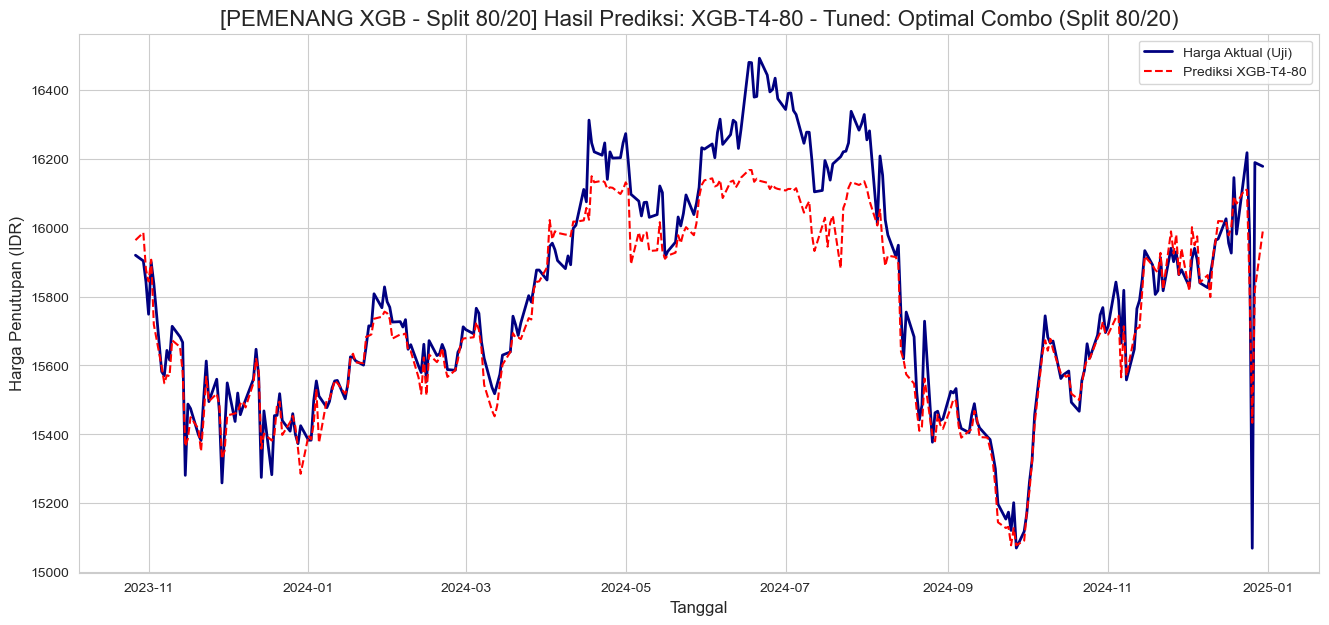

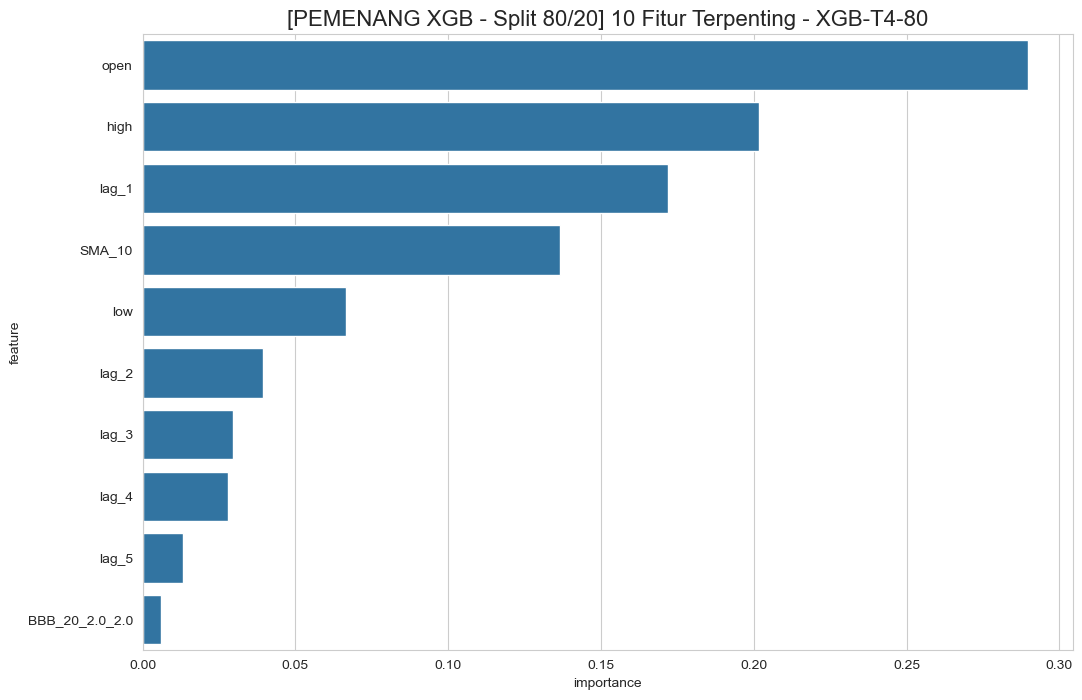


--- METRIK TERBAIK (SPLIT 70/30) ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
XGB-T4-70,XGBRegressor,Tuned: Optimal Combo (Split 70/30),85.857505,56.127491,0.354754,0.962760
XGB-T1-70,XGBRegressor,Tuned: Lower LR (Split 70/30),88.012951,56.459681,0.356769,0.960867
XGB-B-70,XGBRegressor,Baseline (Split 70/30),86.264135,56.813866,0.359483,0.962407
XGB-T3-70,XGBRegressor,Tuned: Regularization (Split 70/30),96.650798,63.122350,0.398256,0.952809
XGB-T2-70,XGBRegressor,Tuned: Shallow Trees (Split 70/30),99.341405,64.694130,0.408069,0.950145



--> PEMENANG (SPLIT 70/30): XGB-T4-70


--- VISUALISASI PEMENANG (SPLIT 70/30) ---

Membuat visualisasi untuk: [PEMENANG XGB - Split 70/30] XGB-T4-70


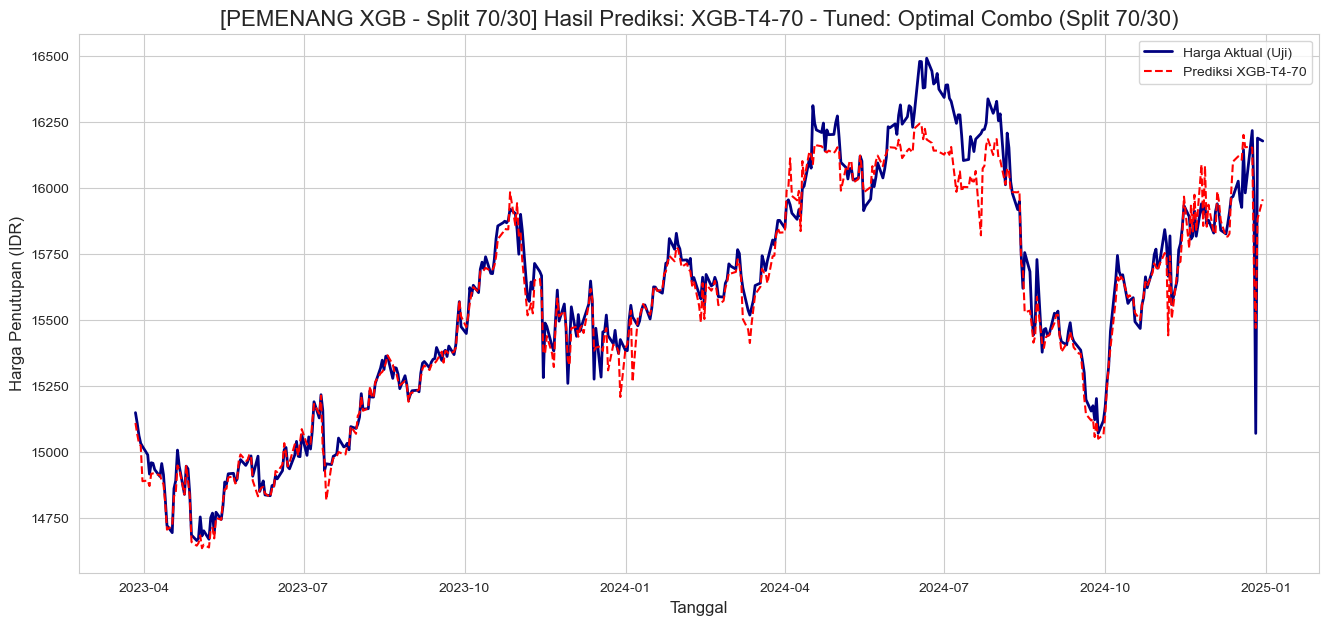

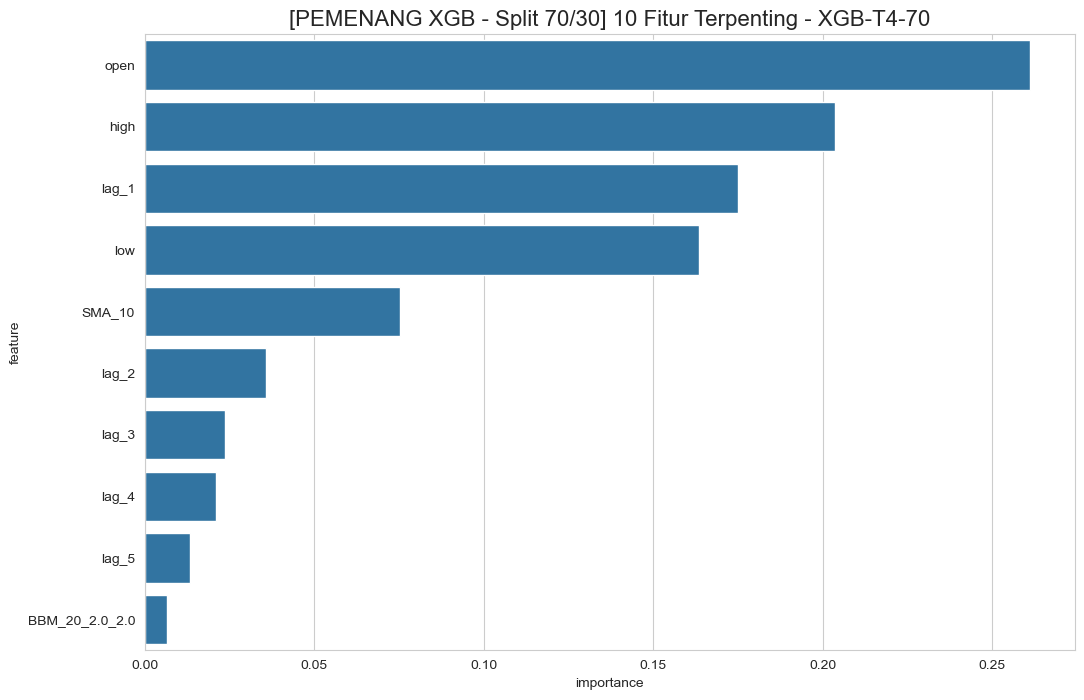


******************************************************************************************
**                       PENENTUAN JUARA KESELURUHAN (XGBOOST)                        **
******************************************************************************************


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
XGB-T4-80,XGBRegressor,Tuned: Optimal Combo (Split 80/20),105.647662,72.765409,0.454486,0.89327
XGB-T4-70,XGBRegressor,Tuned: Optimal Combo (Split 70/30),85.857505,56.127491,0.354754,0.96276



===> JUARA KESELURUHAN XGB adalah: XGB-T4-70!

--- DETAIL SANG JUARA ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
XGB-T4-70,XGBRegressor,Tuned: Optimal Combo (Split 70/30),85.857505,56.127491,0.354754,0.96276


In [13]:

results_df = pd.DataFrame(all_results).set_index('ID')

if not results_df.dropna().empty:
    print("\n" + "#"*90)
    print("##" + " ANALISIS MENDALAM & VISUALISASI HASIL EKSPERIMEN (XGBOOST) ".center(84) + "##")
    print("#"*90 + "\n")


    results_80 = results_df[results_df.index.str.contains('-80')]
    if not results_80.empty:
        best_id_80 = results_80['MAPE (%)'].idxmin()
        print("\n--- METRIK TERBAIK (SPLIT 80/20) ---")
        display(results_80.sort_values('MAPE (%)'))
        print(f"\n--> PEMENANG (SPLIT 80/20): {best_id_80}\n")
        print("\n--- VISUALISASI PEMENANG (SPLIT 80/20) ---")
        best_config_80 = next(c for c in all_configs if c['id'] == best_id_80)
        visualize_experiment(raw_data, best_config_80, models_trained[best_id_80], feature_names_map[best_id_80], title_prefix=f"[PEMENANG XGB - Split 80/20]")


    results_70 = results_df[results_df.index.str.contains('-70')]
    if not results_70.empty:
        best_id_70 = results_70['MAPE (%)'].idxmin()
        print("\n--- METRIK TERBAIK (SPLIT 70/30) ---")
        display(results_70.sort_values('MAPE (%)'))
        print(f"\n--> PEMENANG (SPLIT 70/30): {best_id_70}\n")
        print("\n--- VISUALISASI PEMENANG (SPLIT 70/30) ---")
        best_config_70 = next(c for c in all_configs if c['id'] == best_id_70)
        visualize_experiment(raw_data, best_config_70, models_trained[best_id_70], feature_names_map[best_id_70], title_prefix=f"[PEMENANG XGB - Split 70/30]")

    if 'best_id_70' in locals() and 'best_id_80' in locals():
        winner_80_result = results_df.loc[best_id_80]
        winner_70_result = results_df.loc[best_id_70]
        print("\n" + "*"*90 + "\n**" + " PENENTUAN JUARA KESELURUHAN (XGBOOST) ".center(84) + "**\n" + "*"*90)
        display(pd.DataFrame([winner_80_result, winner_70_result]))
        ultimate_champion_id = results_df['MAPE (%)'].idxmin()
        print(f"\n===> JUARA KESELURUHAN XGB adalah: {ultimate_champion_id}!")
        champion_details = results_df.loc[ultimate_champion_id]
        print("\n--- DETAIL SANG JUARA ---")
        display(pd.DataFrame(champion_details).T)
else:
    print("Tidak ada hasil eksperimen yang berhasil untuk dianalisis.")

In [14]:
#Algoritma SVR
import pandas as pd
import yfinance as yf
import numpy as np
import time
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Library dan konfigurasi awal berhasil dimuat.")

Library dan konfigurasi awal berhasil dimuat.


In [15]:
def create_features(df, feature_config):
    """
    Membuat fitur teknikal berdasarkan konfigurasi yang diberikan.
    """
    df_feat = df.copy()
    if feature_config.get('lags'):
        for i in range(1, 6): df_feat[f'lag_{i}'] = df_feat['close'].shift(i)
    if feature_config.get('indicators'):
        df_feat.ta.sma(10, append=True); df_feat.ta.sma(30, append=True)
        df_feat.ta.rsi(14, append=True); df_feat.ta.bbands(20, append=True)
    df_feat.dropna(inplace=True)
    return df_feat

def prepare_data_for_model(df_features, config):
    """
    Mempersiapkan data (X, y), melakukan splitting, dan scaling.
    """
    y = df_features['close']
    X = df_features.copy()
    X.drop(columns=['close', 'adj_close'], errors='ignore', inplace=True)
    split_idx = int(len(X) * config['split_ratio'])
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, X_train.columns, scaler

def train_and_predict(model, model_params, X_train, y_train, X_test):
    """
    Melatih model dan menghasilkan prediksi.
    """
    model.set_params(**model_params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

def evaluate_predictions(predictions, y_test):
    """
    Mengevaluasi prediksi.
    """
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'MAE': mean_absolute_error(y_test, predictions),
        'MAPE (%)': mean_absolute_percentage_error(y_test, predictions) * 100,
        'R2 Score': r2_score(y_test, predictions)
    }
    return metrics

def run_experiment(data, config):
    """
    Menjalankan satu siklus eksperimen lengkap.
    """
    print(f"-- Menjalankan: {config['id']} ({config['name']})")
    df_with_features = create_features(data, config['features'])
    X_train_scaled, X_test_scaled, y_train, y_test, feature_names, _ = prepare_data_for_model(df_with_features, config)
    model = config['model']
    preds = train_and_predict(model, config['model_params'], X_train_scaled, y_train, X_test_scaled)
    metrics = evaluate_predictions(preds, y_test)
    result = {'ID': config['id'], 'Model': config['model_name'], 'Eksperimen': config['name'], **metrics}
    return result, model, feature_names

def visualize_experiment(data, config, model, feature_names, title_prefix=""):
    """
    Membuat visualisasi untuk hasil eksperimen.
    """
    print(f"\nMembuat visualisasi untuk: {title_prefix} {config['id']}")
    df_with_features = create_features(data, config['features'])
    X_train_scaled, X_test_scaled, y_train, y_test, _, _ = prepare_data_for_model(df_with_features, config)
    

    predictions = train_and_predict(model, config['model_params'], X_train_scaled, y_train, X_test_scaled)
    

    plt.figure(figsize=(16, 7))
    plt.plot(y_test.index, y_test, label='Harga Aktual (Uji)', color='navy', linewidth=2)
    plt.plot(y_test.index, predictions, label=f'Prediksi {config["id"]}', color='red', linestyle='--')
    plt.title(f'{title_prefix} Hasil Prediksi: {config["id"]} - {config["name"]}', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12); plt.ylabel('Harga Penutupan (IDR)', fontsize=12)
    plt.legend(); plt.grid(True); plt.show()


    if hasattr(model, 'feature_importances_') and len(model.feature_importances_) > 0:
        importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=importances.head(10))
        plt.title(f'{title_prefix} 10 Fitur Terpenting - {config["id"]}', fontsize=16)
        plt.show()

print("Fungsi-fungsi utama berhasil didefinisikan.")



Fungsi-fungsi utama berhasil didefinisikan.


In [16]:

nama_file_csv = "dataset_IDR_X_2019_2024.csv"

print(f"Memuat data dari file lokal: {nama_file_csv}...")

raw_data = pd.read_csv(nama_file_csv, index_col=0, parse_dates=True)

raw_data.columns = raw_data.columns.str.lower()
raw_data.columns = raw_data.columns.str.replace(' ', '_')


print("\nData berhasil dimuat dari file CSV.")

print("Verifikasi Tipe Data (Dtype):")
raw_data.info() 


print("\nContoh Data:")
display(raw_data.head())

Memuat data dari file lokal: dataset_IDR_X_2019_2024.csv...

Data berhasil dimuat dari file CSV.
Verifikasi Tipe Data (Dtype):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1564 entries, 2019-01-01 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1564 non-null   float64
 1   high    1564 non-null   float64
 2   low     1564 non-null   float64
 3   open    1564 non-null   float64
 4   volume  1564 non-null   float64
dtypes: float64(5)
memory usage: 73.3 KB

Contoh Data:


,close,high,low,open,volume
Date,,,,,
2019-01-01,14460.000000,14460.0,14460.000000,14460.000000,0.0
2019-01-02,14460.000000,14513.0,14373.000000,14460.000000,0.0
2019-01-03,14409.700195,14502.5,14367.900391,14409.700195,0.0
2019-01-04,14375.400391,14403.0,14211.000000,14375.400391,0.0
2019-01-07,14267.000000,14263.0,14008.000000,14263.000000,0.0


In [17]:

from sklearn.svm import SVR
svr = SVR()


STD_FEATURES = {'lags': True, 'indicators': True}
STD_TARGET = 'absolute'
all_configs = []


block_80_configs = [
    {'id': 'SVR-B-80', 'name': 'Baseline (Split 80/20)', 'model': svr, 'model_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}},
    {'id': 'SVR-T1-80', 'name': 'Tuned: Higher C (Split 80/20)', 'model': svr, 'model_params': {'kernel': 'rbf', 'C': 100, 'gamma': 'scale'}},
    {'id': 'SVR-T2-80', 'name': 'Tuned: Lower C (Split 80/20)', 'model': svr, 'model_params': {'kernel': 'rbf', 'C': 0.1, 'gamma': 'auto'}},
    {'id': 'SVR-T3-80', 'name': 'Tuned: Linear Kernel (Split 80/20)', 'model': svr, 'model_params': {'kernel': 'linear', 'C': 50}},
    {'id': 'SVR-T4-80', 'name': 'Tuned: Aggressive Combo (Split 80/20)', 'model': svr, 'model_params': {'kernel': 'rbf', 'C': 1000, 'gamma': 'auto', 'epsilon': 0.01}},
]
for config in block_80_configs:
    config.update({'features': STD_FEATURES, 'split_ratio': 0.8, 'target': STD_TARGET, 'model_name': 'SVR'})
all_configs.extend(block_80_configs)


block_70_configs = [
    {'id': 'SVR-B-70', 'name': 'Baseline (Split 70/30)', 'model': svr, 'model_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}},
    {'id': 'SVR-T1-70', 'name': 'Tuned: Higher C (Split 70/30)', 'model': svr, 'model_params': {'kernel': 'rbf', 'C': 100, 'gamma': 'scale'}},
    {'id': 'SVR-T2-70', 'name': 'Tuned: Lower C (Split 70/30)', 'model': svr, 'model_params': {'kernel': 'rbf', 'C': 0.1, 'gamma': 'auto'}},
    {'id': 'SVR-T3-70', 'name': 'Tuned: Linear Kernel (Split 70/30)', 'model': svr, 'model_params': {'kernel': 'linear', 'C': 50}},
    {'id': 'SVR-T4-70', 'name': 'Tuned: Aggressive Combo (Split 70/30)', 'model': svr, 'model_params': {'kernel': 'rbf', 'C': 1000, 'gamma': 'auto', 'epsilon': 0.01}},
]
for config in block_70_configs:
    config.update({'features': STD_FEATURES, 'split_ratio': 0.7, 'target': STD_TARGET, 'model_name': 'SVR'})
all_configs.extend(block_70_configs)

print(f"Total {len(all_configs)} konfigurasi eksperimen SVR berhasil dibuat.")

Total 10 konfigurasi eksperimen SVR berhasil dibuat.


In [18]:
all_results = []
models_trained = {}     
feature_names_map = {} 

start_total_time = time.time()

for config in all_configs:
    try:
        result, trained_model, feature_names = run_experiment(raw_data, config)
        all_results.append(result)
        models_trained[config['id']] = trained_model
        feature_names_map[config['id']] = feature_names

        print("--- Hasil Evaluasi Selesai ---")
        display(pd.DataFrame([result]).set_index('ID'))
        print("-" * 70)
        
    except Exception as e:
        print(f"!!! GAGAL: {config['id']} ({config['name']}) - Error: {e}")
        all_results.append({
            'ID': config['id'], 'Model': config['model_name'], 'Eksperimen': config['name'], 
            'RMSE': np.nan, 'MAE': np.nan, 'MAPE (%)': np.nan, 'R2 Score': np.nan
        })

end_total_time = time.time()
print(f"\n\nEKSEKUSI SEMUA {len(all_configs)} EKSPERIMEN SELESAI.")
print(f"Total waktu yang dibutuhkan: {((end_total_time - start_total_time) / 60):.2f} menit.")

-- Menjalankan: SVR-B-80 (Baseline (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-B-80,SVR,Baseline (Split 80/20),1164.253435,1101.999774,6.929794,-11.961683


----------------------------------------------------------------------
-- Menjalankan: SVR-T1-80 (Tuned: Higher C (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-T1-80,SVR,Tuned: Higher C (Split 80/20),448.933702,282.845256,1.752206,-0.927218


----------------------------------------------------------------------
-- Menjalankan: SVR-T2-80 (Tuned: Lower C (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-T2-80,SVR,Tuned: Lower C (Split 80/20),1378.985548,1339.22285,8.437743,-17.183848


----------------------------------------------------------------------
-- Menjalankan: SVR-T3-80 (Tuned: Linear Kernel (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-T3-80,SVR,Tuned: Linear Kernel (Split 80/20),23.061606,13.817661,0.087848,0.994914


----------------------------------------------------------------------
-- Menjalankan: SVR-T4-80 (Tuned: Aggressive Combo (Split 80/20))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-T4-80,SVR,Tuned: Aggressive Combo (Split 80/20),330.617257,191.71501,1.186521,-0.045243


----------------------------------------------------------------------
-- Menjalankan: SVR-B-70 (Baseline (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-B-70,SVR,Baseline (Split 70/30),1111.633772,999.763122,6.334692,-5.242684


----------------------------------------------------------------------
-- Menjalankan: SVR-T1-70 (Tuned: Higher C (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-T1-70,SVR,Tuned: Higher C (Split 70/30),419.193942,230.45163,1.430617,0.112276


----------------------------------------------------------------------
-- Menjalankan: SVR-T2-70 (Tuned: Lower C (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-T2-70,SVR,Tuned: Lower C (Split 70/30),1272.429697,1190.541959,7.567073,-7.179287


----------------------------------------------------------------------
-- Menjalankan: SVR-T3-70 (Tuned: Linear Kernel (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-T3-70,SVR,Tuned: Linear Kernel (Split 70/30),26.554932,15.664571,0.100642,0.996438


----------------------------------------------------------------------
-- Menjalankan: SVR-T4-70 (Tuned: Aggressive Combo (Split 70/30))
--- Hasil Evaluasi Selesai ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-T4-70,SVR,Tuned: Aggressive Combo (Split 70/30),331.863193,166.575518,1.031959,0.443627


----------------------------------------------------------------------


EKSEKUSI SEMUA 10 EKSPERIMEN SELESAI.
Total waktu yang dibutuhkan: 0.04 menit.



##########################################################################################
##               ANALISIS MENDALAM & VISUALISASI HASIL EKSPERIMEN (SVR)               ##
##########################################################################################


--- METRIK TERBAIK (SPLIT 80/20) ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-T3-80,SVR,Tuned: Linear Kernel (Split 80/20),23.061606,13.817661,0.087848,0.994914
SVR-T4-80,SVR,Tuned: Aggressive Combo (Split 80/20),330.617257,191.715010,1.186521,-0.045243
SVR-T1-80,SVR,Tuned: Higher C (Split 80/20),448.933702,282.845256,1.752206,-0.927218
SVR-B-80,SVR,Baseline (Split 80/20),1164.253435,1101.999774,6.929794,-11.961683
SVR-T2-80,SVR,Tuned: Lower C (Split 80/20),1378.985548,1339.222850,8.437743,-17.183848



--> PEMENANG (SPLIT 80/20): SVR-T3-80


--- VISUALISASI PEMENANG (SPLIT 80/20) ---

Membuat visualisasi untuk: [PEMENANG SVR - Split 80/20] SVR-T3-80


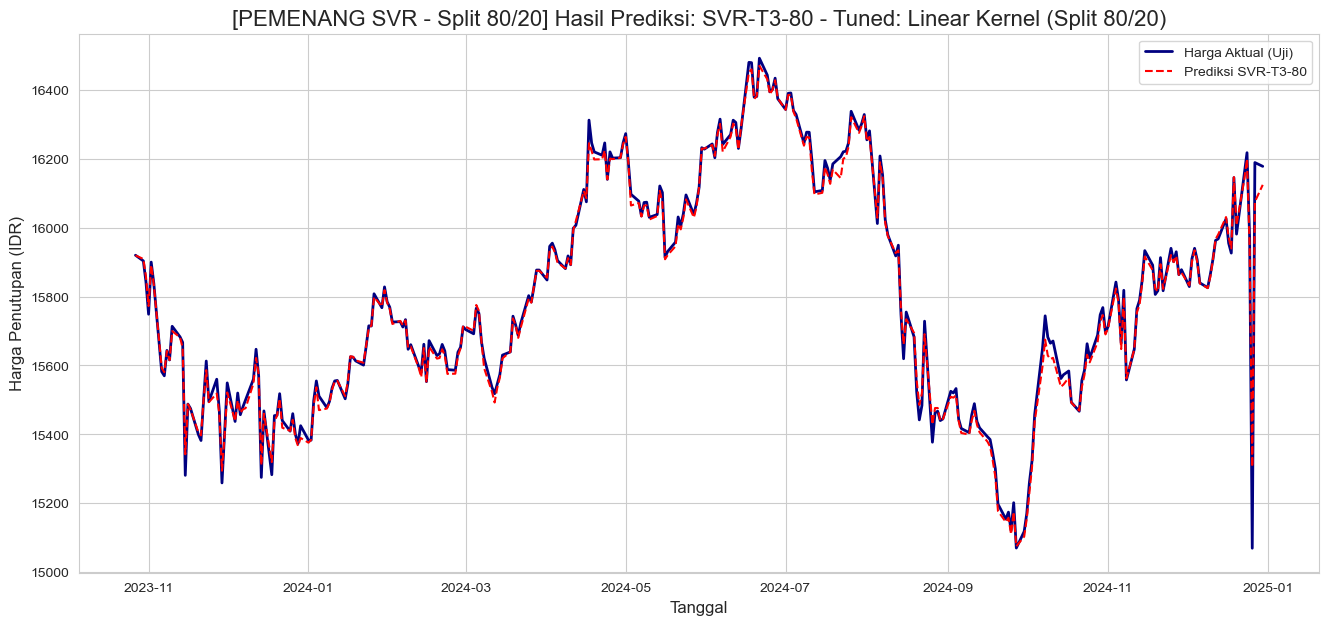


--- METRIK TERBAIK (SPLIT 70/30) ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
ID,,,,,,
SVR-T3-70,SVR,Tuned: Linear Kernel (Split 70/30),26.554932,15.664571,0.100642,0.996438
SVR-T4-70,SVR,Tuned: Aggressive Combo (Split 70/30),331.863193,166.575518,1.031959,0.443627
SVR-T1-70,SVR,Tuned: Higher C (Split 70/30),419.193942,230.451630,1.430617,0.112276
SVR-B-70,SVR,Baseline (Split 70/30),1111.633772,999.763122,6.334692,-5.242684
SVR-T2-70,SVR,Tuned: Lower C (Split 70/30),1272.429697,1190.541959,7.567073,-7.179287



--> PEMENANG (SPLIT 70/30): SVR-T3-70


--- VISUALISASI PEMENANG (SPLIT 70/30) ---

Membuat visualisasi untuk: [PEMENANG SVR - Split 70/30] SVR-T3-70


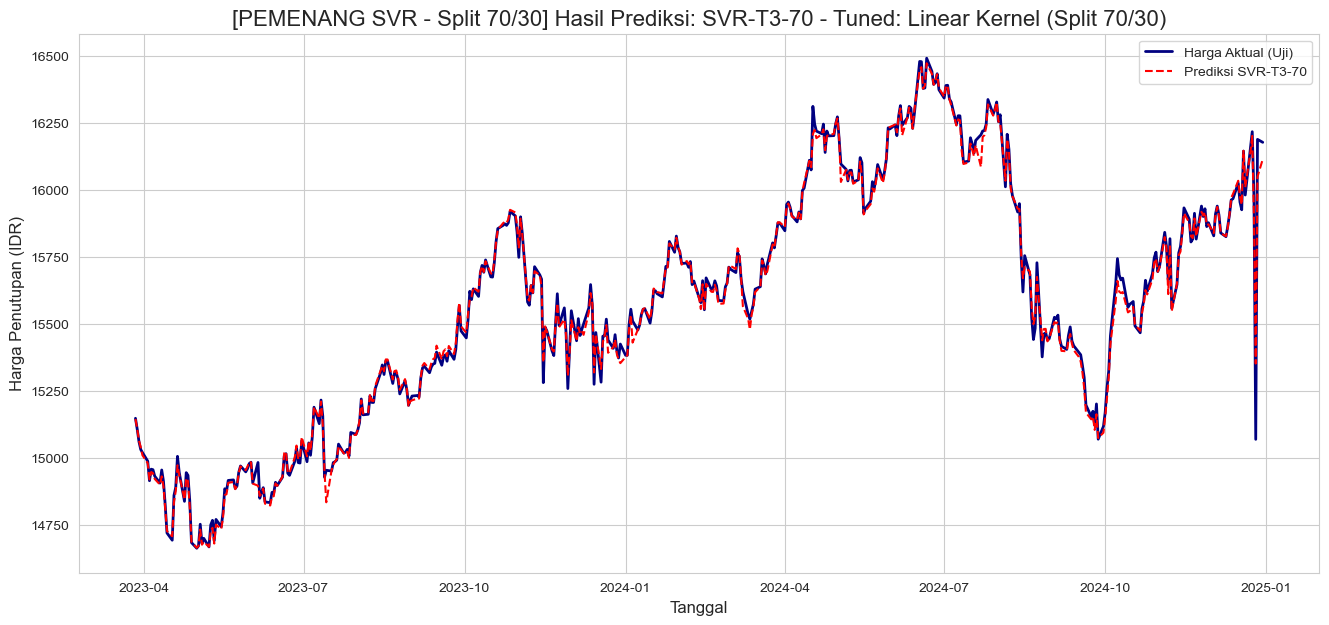


******************************************************************************************
**                         PENENTUAN JUARA KESELURUHAN (SVR)                          **
******************************************************************************************


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
SVR-T3-80,SVR,Tuned: Linear Kernel (Split 80/20),23.061606,13.817661,0.087848,0.994914
SVR-T3-70,SVR,Tuned: Linear Kernel (Split 70/30),26.554932,15.664571,0.100642,0.996438



===> JUARA KESELURUHAN SVR adalah: SVR-T3-80!

--- DETAIL SANG JUARA ---


,Model,Eksperimen,RMSE,MAE,MAPE (%),R2 Score
SVR-T3-80,SVR,Tuned: Linear Kernel (Split 80/20),23.061606,13.817661,0.087848,0.994914


In [19]:
results_df = pd.DataFrame(all_results).set_index('ID')

if not results_df.dropna().empty:
    print("\n" + "#"*90)
    print("##" + " ANALISIS MENDALAM & VISUALISASI HASIL EKSPERIMEN (SVR) ".center(84) + "##")
    print("#"*90 + "\n")


    results_80 = results_df[results_df.index.str.contains('-80')]
    if not results_80.empty:
        best_id_80 = results_80['MAPE (%)'].idxmin()
        print("\n--- METRIK TERBAIK (SPLIT 80/20) ---")
        display(results_80.sort_values('MAPE (%)'))
        print(f"\n--> PEMENANG (SPLIT 80/20): {best_id_80}\n")
        print("\n--- VISUALISASI PEMENANG (SPLIT 80/20) ---")
        best_config_80 = next(c for c in all_configs if c['id'] == best_id_80)
        visualize_experiment(raw_data, best_config_80, models_trained[best_id_80], feature_names_map[best_id_80], title_prefix=f"[PEMENANG SVR - Split 80/20]")


    results_70 = results_df[results_df.index.str.contains('-70')]
    if not results_70.empty:
        best_id_70 = results_70['MAPE (%)'].idxmin()
        print("\n--- METRIK TERBAIK (SPLIT 70/30) ---")
        display(results_70.sort_values('MAPE (%)'))
        print(f"\n--> PEMENANG (SPLIT 70/30): {best_id_70}\n")
        print("\n--- VISUALISASI PEMENANG (SPLIT 70/30) ---")
        best_config_70 = next(c for c in all_configs if c['id'] == best_id_70)
        visualize_experiment(raw_data, best_config_70, models_trained[best_id_70], feature_names_map[best_id_70], title_prefix=f"[PEMENANG SVR - Split 70/30]")


    if not results_70.empty and not results_80.empty:
        winner_80_result = results_df.loc[best_id_80]
        winner_70_result = results_df.loc[best_id_70]
        print("\n" + "*"*90 + "\n**" + " PENENTUAN JUARA KESELURUHAN (SVR) ".center(84) + "**\n" + "*"*90)
        display(pd.DataFrame([winner_80_result, winner_70_result]))
        ultimate_champion_id = results_df['MAPE (%)'].idxmin()
        print(f"\n===> JUARA KESELURUHAN SVR adalah: {ultimate_champion_id}!")
        champion_details = results_df.loc[ultimate_champion_id]
        print("\n--- DETAIL SANG JUARA ---")
        display(pd.DataFrame(champion_details).T)
else:
    print("Tidak ada hasil eksperimen yang berhasil untuk dianalisis.")